# Datenanalyse Unknown

In [1]:
# Base
import numpy as np
import pandas as pd
import gc
from tqdm import tqdm
import seaborn as sns
from datetime import datetime

# Visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns


# Scoring
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Daten laden

In [2]:
train_events = pd.read_csv('../../data/raw/train_events.csv')

##  Cleaning

In [3]:
### PARAMS
ANGLEZ_VARIANCE_SEQUENCE_LENGTH = 6 * 60 * 12 # 8h
ANGLEZ_REPETITION_SEQUENCE_LENGTH = 4 * 60 * 12 # 4h

UNKNOWN_BUFFER = 0.5 * 60 * 12 # 0.5h
CLEAN_BUFFER = 3 * 60 * 12 # 2h

In [4]:
def mark_unknown(series, events):
    series['unknown'] = 0

    previous_defined_event = None
    for index, current_event in events.iterrows():
        if np.isnan(current_event['step']):
            next_events = events[index:]
            next_defined_events = next_events[next_events['step'].notna()]
            next_defined_event = next_defined_events.iloc[0] if len(next_defined_events) > 0 else None

            unknown_start_step = previous_defined_event['step'] + UNKNOWN_BUFFER if previous_defined_event is not None else 0
            unknown_end_step = next_defined_event['step'] - UNKNOWN_BUFFER if next_defined_event is not None else series.iloc[-1]['step'] + 1

            series.loc[unknown_start_step:unknown_end_step, 'unknown'] = 1

            continue

        previous_defined_event = current_event
    
    ## Fix if after last event are many more steps
    last_event = events.iloc[-1]
    
    if not(np.isnan(last_event['step'])):
        last_step = series.iloc[-1]
        last_event_date = datetime.strptime(last_event['timestamp'][0:10], '%Y-%m-%d').date()
        last_step_date = datetime.strptime(last_step['timestamp'][0:10], '%Y-%m-%d').date()
    
        if last_event_date < last_step_date:
            series.loc[last_event['step'] + UNKNOWN_BUFFER:, 'unknown'] = 1
        
    return series

In [5]:
def mark_clean_anglez_too_low_variance(series):
    last_step = series.iloc[-1]['step']       
    
    for current_start_step in range(0, len(series), ANGLEZ_VARIANCE_SEQUENCE_LENGTH):
        current_end_step = current_start_step + ANGLEZ_VARIANCE_SEQUENCE_LENGTH

        series_chunk = series[current_start_step:current_end_step]

        series_chunk_anglez = series_chunk['anglez'].abs()
        if not (series_chunk_anglez > 50).any():
            clean_from = max(0, current_start_step - CLEAN_BUFFER)
            clean_to = min(last_step, current_end_step + CLEAN_BUFFER)
            
            series.loc[clean_from:clean_to, 'clean'] = 1

    return series

In [6]:
def mark_clean_repetition(series):
    last_step = series.iloc[-1]['step']       

    for current_start_step in range(0, len(series), ANGLEZ_REPETITION_SEQUENCE_LENGTH):
        current_end_step = current_start_step + ANGLEZ_REPETITION_SEQUENCE_LENGTH

        series_chunk = series[current_start_step:current_end_step].reset_index(drop=True)

        for comparing_start_step in range(current_end_step, len(series), ANGLEZ_REPETITION_SEQUENCE_LENGTH):
            comparing_end_step = comparing_start_step + ANGLEZ_REPETITION_SEQUENCE_LENGTH
            comparing_series_chunk = series[comparing_start_step:comparing_end_step].reset_index(drop=True)

            if series_chunk['anglez'].equals(comparing_series_chunk['anglez']):
                clean_from = max(0, current_start_step - CLEAN_BUFFER)
                clean_to = min(last_step, current_end_step + CLEAN_BUFFER)
                series.loc[clean_from:clean_to, 'clean'] = 1
                
                clean_from = max(0, comparing_start_step - CLEAN_BUFFER)
                clean_to = min(last_step, comparing_end_step + CLEAN_BUFFER)
                series.loc[clean_from:clean_to, 'clean'] = 1

    return series

In [7]:
def mark_clean(series):
    series['clean'] = 0

    series = mark_clean_anglez_too_low_variance(series)
    series = mark_clean_repetition(series)

    return series

In [8]:
def cleaning(series_id):
    events = pd.read_csv('../../data/raw/train_events.csv')
    events = events[events.series_id == series_id].reset_index(drop=True)
    series = pd.read_parquet('../../data/raw/train_series.parquet', filters=[('series_id', '=', series_id)])
    
    series = mark_unknown(series, events)
    series = mark_clean(series)
    return series

In [9]:
series_data = []

for series_id in tqdm(train_events.series_id.unique()):
    series = cleaning(series_id)
    series_data.append(series)
    
    del series
    gc.collect()

train_series_cleaned = pd.concat(series_data).reset_index(drop=True)

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [40:17<00:00,  8.73s/it]


## Evaluation

In [10]:
accuracy_score(train_series_cleaned['unknown'], train_series_cleaned['clean'])

0.8829841478857465

In [11]:
recall_score(train_series_cleaned['unknown'], train_series_cleaned['clean'])

0.7238933908686597

In [12]:
precision_score(train_series_cleaned['unknown'], train_series_cleaned['clean'])

0.9755080564052998

In [13]:
f1_score(train_series_cleaned['unknown'], train_series_cleaned['clean'])

0.8310735946514559

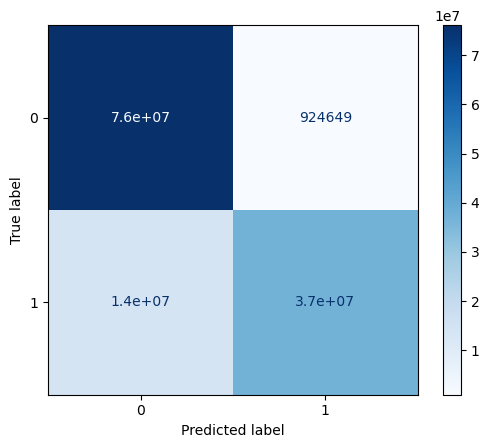

In [14]:
cm = confusion_matrix(train_series_cleaned['unknown'], train_series_cleaned['clean'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

## Daten speichern für weitere Analysen

In [15]:
train_series_cleaned.to_parquet('../../data/cleaning_analysis_new_v4.parquet')